#### <b>필요한 라이브러리 설치</b>

In [22]:
# # 트랜스포머 라이브러리 설치(Huggig Face에 있는 모델 불러오기 가능)
# !pip install transformers
# !pip install datasets # 데이터 세트 다운로드 Hugging Face와 연동

#### <b>필요한 라이브러리 불러오기</b>

In [23]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [24]:
import torch

# GPU 사용 가능 여부 확인
print("CUDA Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    # 현재 활성화된 GPU 인덱스 확인
    print("Current GPU Index:", torch.cuda.current_device())
    
    # 현재 활성화된 GPU의 이름 확인
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    
    # GPU 메모리 사용량 확인
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 0
GPU Memory Cached: 0


In [25]:
df = pd.read_csv("train_dataset.csv")
df.fillna(0)
df["비속어"].value_counts()

0.0    15394
1.0     9704
Name: 비속어, dtype: int64

In [26]:
df["선호도"].value_counts()

2.0    13831
1.0     7465
0.0     2307
3.0     1271
4.0      224
Name: 선호도, dtype: int64

In [27]:
print(df["성"].value_counts())
print()
print(df["정치"].value_counts())
print()
print(df["국가"].value_counts())
print()
print(df["인종"].value_counts())
print()
print(df["지역"].value_counts())
print()
print(df["사회계층"].value_counts())
print()
print(df["외모"].value_counts())
print()
print(df["기타"].value_counts())

0.0    22975
1.0     2123
Name: 성, dtype: int64

0.0    23535
1.0     1563
Name: 정치, dtype: int64

0.0    23828
1.0     1270
Name: 국가, dtype: int64

0.0    23803
1.0     1295
Name: 인종, dtype: int64

0.0    24777
1.0      321
Name: 지역, dtype: int64

0.0    24616
1.0      482
Name: 사회계층, dtype: int64

0.0    24687
1.0      411
Name: 외모, dtype: int64

0.0    21999
1.0     3099
Name: 기타, dtype: int64


#### <b>학습할 모델 관련 라이브러리 불러오기</b>

In [28]:
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BigBirdConfig, AutoConfig

In [29]:
from transformers import AutoModel, AutoTokenizer, BigBirdConfig

config = BigBirdConfig.from_pretrained("monologg/kobigbird-bert-base", attention_type='original_full')

model = AutoModel.from_pretrained("monologg/kobigbird-bert-base", config=config)

tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
text = "한국어 BigBird 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
output = model(**encoded_input)

#### <b>실험을 위한 하이퍼 파라미터 설정</b>

In [30]:
# SimpleNamespace는 온점(.)으로 속성의 값을 정의할 수 있도록 해주는 라이브러리
# config.task = "cls"라고 하면, 나중에 print(config.task)했을 때 "cls"라고 출력
from types import SimpleNamespace

config = SimpleNamespace()

config.task = "bigbird_cls_bias"
config.dataset = "comment"

config.cache_dir = "bigbird_cls_bias_cache" # 현재 데이터 세트에 대한 단어집 등 현재 task를 위한 임시적인 폴더
config.output_dir = "bigbird_cls_bias_output" # 최종적인 모델이 저장되고, 결과가 저장되는 폴더

config.use_tpu = False
config.model_name_or_path = "monologg/kobigbird-bert-base" # Model name or path (HuggingFace에서 불러와 사용할 모델 이름)
config.data_dir = "./" # The input data dir ("10000_labeled.csv"가 있는 경로)

config.train_file = "train_dataset.csv" 
config.predict_file = "test_dataset.csv" # → 나중에 생기면 갈아끼우기

config.max_seq_length = 512
config.train_batch_size = 8 # Batch size for training. (학습할 때 batch_size)
config.eval_batch_size = 4 # Batch size for evaluation. (평가할 때 batch_size)

config.learning_rate = 3e-5 # The initial learning rate for Adam. (Adam optimizer에서 쓸 learning rate)
config.num_train_epochs = 10 # Total number of training epochs to perform. (전체 학습 epoch 수)

# config.preference_classes = 5
# config.slang_classes = 1
# config.politic_classes = 1
config.gradient_accumulation_steps = 2 # Number of updates steps to accumulate before performing a backward/update pass.
# batch_size가 큰 것처럼 처리하기 위해서, backward()를 매 번 수행하지 않고, gradient를 누적(acculmulation)하는 것

config.threads = 4
config.seed = 42 

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

#### <b>학습 데이터 전처리</b>

* 학습 텍스트를 매번 tokenizing을 하지 않고, <b>모델 학습 시작 전에 미리 모든 텍스트를 tokenizing</b> 한 결과를 저장한다.
  * 이렇게 했을 때, 결과적인 속도는 훨씬 빠르기 때문이다.

In [31]:
# 본 실습에서 사용할 tokenizer 객체 초기화
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, cache_dir=config.cache_dir)

In [32]:
def train_split(config, texts, labels, is_train):
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    df = pd.read_csv(data_file)
    df = df.fillna(0)  # nan값 0으로 채우기
    df = df[df["선호도"]!= -1] # 선호도 -1 인 문장 학습에서 배제
    #df = df[:700]
    genders = df["성"].astype(int).values.tolist()
    politics = df["정치"].astype(int).values.tolist()
    nations = df["국가"].astype(int).values.tolist()
    races = df["인종"].astype(int).values.tolist()
    regions = df["지역"].astype(int).values.tolist()
    generations= df["세대"].astype(int).values.tolist()
    social_clss = df["사회계층"].astype(int).values.tolist()
    appearences = df["외모"].astype(int).values.tolist()
    others = df["기타"].astype(int).values.tolist()
    labels = []
    for i in range(len(genders)):
        gender = genders[i] # 성
        politic = politics[i] # 정치
        nation = nations[i]
        race = races[i]
        region = regions[i]
        generation = generations[i]
        social_cls = social_clss[i]
        appearence = appearences[i]
        other = others[i]
        labels.append([gender, politic, nation, race, region, generation, social_cls, appearence, other])
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train)
    return texts, labels

In [33]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"

    # 실제로 tokenizer를  저장될 데이터 세트의 파일 이름이 바로 dataset_file
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)

    # 기존에 write_samples() 함수가 하는 역할: 텍스트 문장을 읽어와서 token 값만 저장
    # 멀티 쓰레드 방식으로 구현되어 있어서, 더 (비효율적이지만) 이해하기 쉬운 코드로 돌려 놓음
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "gender": int(label[0]),
                "politic": int(label[1]), 
                "nation" : int(label[2]),
                "race" : int(label[3]),
                "region" : int(label[4]),
                "generation" : int(label[5]),
                "social_cls" : int(label[6]),
                "appearence" : int(label[7]),
                "other": int(label[8]),
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [34]:
if config.do_train:
    # 학습 데이터 세트 전처리
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)

# 평가 데이터 세트 전처리(validation = dev 같은 의미)
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./train_dataset.csv_comment_monologg_kobigbird-bert-base_512_train_dataset.txt
20078 features processed from ./train_dataset.csv
dataset_file: ./test_dataset.csv_comment_monologg_kobigbird-bert-base_512_dev_dataset.txt
401 features processed from ./test_dataset.csv


#### <b>데이터 로더 초기화</b>

In [35]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Wait to have a full batch before yielding elements.
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []

        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [36]:
def collate_fn(features):
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    gender = [sample["gender"] for sample in features]
    politic = [sample["politic"] for sample in features]
    nation = [sample["nation"] for sample in features]
    race = [sample["race"] for sample in features]
    region = [sample["region"] for sample in features]
    generation = [sample["generation"] for sample in features]
    social_cls = [sample["social_cls"] for sample in features]
    appearence = [sample["appearence"] for sample in features]
    other = [sample["other"] for sample in features]

    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    gender = torch.tensor(np.array(gender).astype(np.int64), dtype=torch.float)
    politic = torch.tensor(np.array(politic).astype(np.int64), dtype=torch.float)
    nation = torch.tensor(np.array(nation).astype(np.int64), dtype=torch.float)
    race = torch.tensor(np.array(race).astype(np.int64), dtype=torch.float)
    region = torch.tensor(np.array(region).astype(np.int64), dtype=torch.float)
    generation = torch.tensor(np.array(generation).astype(np.int64), dtype=torch.float)
    social_cls = torch.tensor(np.array(social_cls).astype(np.int64), dtype=torch.float)
    appearence = torch.tensor(np.array(appearence).astype(np.int64), dtype=torch.float)
    other = torch.tensor(np.array(other).astype(np.int64), dtype=torch.float)
    
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels = {
        "gender" : gender,
        "politic": politic,
        "nation" :nation, 
        "race" : race,
        "region" : region,
        "generation" : generation,
        "social_cls" : social_cls,
        "appearence" : appearence,
        "other" : other,
    }
    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/20078 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

#### <b>텍스트 분류 모델 정의</b>

In [37]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  # (전처리된) 학습할 데이터 세트의 경로 설정
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=5)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        
        self.activation = nn.ReLU()
        
        self.layer1 = nn.Linear(768, 384)
        self.layer2 = nn.Linear(768, 384)
        self.layer3 = nn.Linear(768, 384)
        self.layer4 = nn.Linear(768, 384)
        self.layer5 = nn.Linear(768, 384)
        self.layer6 = nn.Linear(768, 384)
        self.layer7 = nn.Linear(768, 384)
        self.layer8 = nn.Linear(768, 384)
        self.layer9 = nn.Linear(768, 384)
        
        
        self.classifier1 = nn.Linear(384, 1) # 선호도 분류기
        self.classifier2 = nn.Linear(384, 1) # 비속어 분류기
        self.classifier3 = nn.Linear(384, 1) # 정치 편향 분류기
        self.classifier4 = nn.Linear(384, 1)
        self.classifier5 = nn.Linear(384, 1)
        self.classifier6 = nn.Linear(384, 1)
        self.classifier7 = nn.Linear(384, 1)
        self.classifier8 = nn.Linear(384, 1)
        self.classifier9 = nn.Linear(384, 1)

        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): # 현재 모델을 학습하기 위한 최적화 방법(AdamW) 객체를 불러오는 함수
        # bias랑 LayerNorm에는 decay 적용하지 않겠다는 의미
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        if config.warmup_proportion == 0.0:
            return None

        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs)
        # 마지막 레이어의 [CLS] 토큰만 가져오기
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        #x_shared = self.activation(self.shared_layer(cls_token_embeddings))
        
        x1 = self.activation(self.layer1(cls_token_embeddings))
        x2 = self.activation(self.layer2(cls_token_embeddings))
        x3 = self.activation(self.layer3(cls_token_embeddings))
        x4 = self.activation(self.layer4(cls_token_embeddings))
        x5 = self.activation(self.layer5(cls_token_embeddings))
        x6 = self.activation(self.layer6(cls_token_embeddings))
        x7 = self.activation(self.layer7(cls_token_embeddings))
        x8 = self.activation(self.layer8(cls_token_embeddings))
        x9 = self.activation(self.layer9(cls_token_embeddings))
        
        output_1 = torch.sigmoid(self.classifier1(x1))
        output_2 = torch.sigmoid(self.classifier2(x2))
        output_3 = torch.sigmoid(self.classifier3(x3)) 
        output_4 = torch.sigmoid(self.classifier4(x4))
        output_5 = torch.sigmoid(self.classifier5(x5))
        output_6 = torch.sigmoid(self.classifier6(x6))
        output_7 = torch.sigmoid(self.classifier7(x7))
        output_8 = torch.sigmoid(self.classifier8(x8))
        output_9 = torch.sigmoid(self.classifier9(x9))

        return output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8, output_9 
    

    def eval_step(self, inputs, labels, outputs):
        logits_1 = outputs[0].detach().cpu()
        logits_2 = outputs[1].detach().cpu()
        logits_3 = outputs[2].detach().cpu()
        logits_4 = outputs[3].detach().cpu()
        logits_5 = outputs[4].detach().cpu()
        logits_6 = outputs[5].detach().cpu()
        logits_7 = outputs[6].detach().cpu()
        logits_8 = outputs[7].detach().cpu()
        logits_9 = outputs[8].detach().cpu()
        
        labels_1 = self.tensor_to_list(labels["gender"])
        labels_2 = self.tensor_to_list(labels["politic"])
        labels_3 = self.tensor_to_list(labels["nation"])
        labels_4 = self.tensor_to_list(labels["race"])
        labels_5 = self.tensor_to_list(labels["region"])
        labels_6 = self.tensor_to_list(labels["generation"])
        labels_7 = self.tensor_to_list(labels["social_cls"])
        labels_8 = self.tensor_to_list(labels["appearence"])
        labels_9 = self.tensor_to_list(labels["other"])
        
        threshold = 0.5
        predictions_1 = self.tensor_to_list((logits_1 > threshold).int())
        predictions_2 = self.tensor_to_list((logits_2 > threshold).int())
        predictions_3 = self.tensor_to_list((logits_3 > threshold).int())
        predictions_4 = self.tensor_to_list((logits_4 > threshold).int())
        predictions_5 = self.tensor_to_list((logits_5 > threshold).int())
        predictions_6 = self.tensor_to_list((logits_6 > threshold).int())
        predictions_7 = self.tensor_to_list((logits_7 > threshold).int())
        predictions_8 = self.tensor_to_list((logits_8 > threshold).int())
        predictions_9 = self.tensor_to_list((logits_9 > threshold).int())

        results_1 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_1, labels_1)]
        results_2 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_2, labels_2)]
        results_3 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_3, labels_3)]
        results_4 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_4, labels_4)]
        results_5 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_5, labels_5)]
        results_6 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_6, labels_6)]
        results_7 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_7, labels_7)]
        results_8 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_8, labels_8)]
        results_9 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_9, labels_9)]
        
        return {"results_1": results_1, "results_2": results_2, "results_3": results_3, "results_4": results_4, "results_5": results_5, "results_6": results_6, "results_7": results_7, "results_8": results_8, "results_9": results_9}

    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [38]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

#### <b>모델 학습 및 평가 라이브러리</b>

In [39]:
from functools import partial
import sklearn.metrics as sklearn_metrics

# for binary-classification
binary_metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "precision": sklearn_metrics.precision_score, # TP / (TP + FP)
    "recall": sklearn_metrics.recall_score, # recall = sensitivity (민감도)
    "f1": sklearn_metrics.f1_score,
    "matthews_corrcoef": sklearn_metrics.matthews_corrcoef,
    "roc_auc": sklearn_metrics.roc_auc_score,
}

def eval_cls(results_1, results_2, results_3, results_4, results_5, results_6, results_7, results_8, results_9, **kwargs):
    
    predictions_1 = np.array([result["prediction"] for result in results_1])
    labels_1 = np.array([result["label"] for result in results_1])
    predictions_2 = np.array([result["prediction"] for result in results_2])
    labels_2 = np.array([result["label"] for result in results_2])
    predictions_3 = np.array([result["prediction"] for result in results_3])
    labels_3 = np.array([result["label"] for result in results_3])
    predictions_3 = np.array([result["prediction"] for result in results_3])
    labels_3 = np.array([result["label"] for result in results_3])
    predictions_4 = np.array([result["prediction"] for result in results_4])
    labels_4 = np.array([result["label"] for result in results_4])
    predictions_5 = np.array([result["prediction"] for result in results_5])
    labels_5 = np.array([result["label"] for result in results_5])
    predictions_6 = np.array([result["prediction"] for result in results_6])
    labels_6 = np.array([result["label"] for result in results_6])
    predictions_7 = np.array([result["prediction"] for result in results_7])
    labels_7 = np.array([result["label"] for result in results_7])
    predictions_8 = np.array([result["prediction"] for result in results_8])
    labels_8 = np.array([result["label"] for result in results_8])
    predictions_9 = np.array([result["prediction"] for result in results_9])
    labels_9 = np.array([result["label"] for result in results_9])

    results_1 = {metric: round(f(labels_1, predictions_1) * 100, 2) for metric, f in binary_metrics.items()}
    results_2 = {metric: round(f(labels_2, predictions_2) * 100, 2) for metric, f in binary_metrics.items()}
    results_3 = {metric: round(f(labels_3, predictions_3) * 100, 2) for metric, f in binary_metrics.items()}
    results_4 = {metric: round(f(labels_3, predictions_4) * 100, 2) for metric, f in binary_metrics.items()}
    results_5 = {metric: round(f(labels_3, predictions_5) * 100, 2) for metric, f in binary_metrics.items()}
    results_6 = {metric: round(f(labels_3, predictions_6) * 100, 2) for metric, f in binary_metrics.items()}
    results_7 = {metric: round(f(labels_3, predictions_7) * 100, 2) for metric, f in binary_metrics.items()}
    results_8 = {metric: round(f(labels_3, predictions_8) * 100, 2) for metric, f in binary_metrics.items()}
    results_9 = {metric: round(f(labels_3, predictions_9) * 100, 2) for metric, f in binary_metrics.items()}

    return {"results_1": results_1, "results_2": results_2,"results_3": results_3, "results_4": results_4, "results_5": results_5,
        "results_6": results_6, "results_7": results_7, "results_8": results_8, "results_9": results_9,
        "best_score_1": results_1["f1"], "best_score_2": results_2["f1"],"best_score_3": results_3["f1"], "best_score_4": results_4["f1"], "best_score_5": results_5["f1"],"best_score_6": results_6["f1"],
        "best_score_7": results_7["f1"],"best_score_8": results_8["f1"],"best_score_9": results_9["f1"]}

In [40]:
# _run_epoch() 함수는, 우리가 흔히 알고있는 학습 함수와 동일
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)

    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()

    is_master = True

    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrected_1, corrected_2, corrected_3, corrected_4, corrected_5, corrected_6, corrected_7, corrected_8, corrected_9 = 0, 0, 0, 0, 0, 0, 0, 0, 0
    total = 0
    
    for i, (inputs, labels) in pbar:
        if not config.use_tpu:
            for k, v in inputs.items():
                if isinstance(v, torch.Tensor):
                    inputs[k] = v.to(device)
            for k, v in labels.items():
                if isinstance(v, torch.Tensor):
                    labels[k] = v.to(device)

        outputs = model(inputs)

        outputs_1 = outputs[0]
        outputs_2 = outputs[1]
        outputs_3 = outputs[2]
        outputs_4 = outputs[3]
        outputs_5 = outputs[4]
        outputs_6 = outputs[5]
        outputs_7 = outputs[6]
        outputs_8 = outputs[7]
        outputs_9 = outputs[8]

        labels_1 = labels["gender"]
        labels_2 = labels["politic"]
        labels_3 = labels["nation"]
        labels_4 = labels["race"]
        labels_5 = labels["region"]
        labels_6 = labels["generation"]
        labels_7 = labels["social_cls"]
        labels_8 = labels["appearence"]
        labels_9 = labels["other"]

        total += outputs_1.shape[0] # batch_size만큼 더해주기

        threshold = 0.5
        loss_function = nn.BCELoss()
        
        loss_1 = loss_function(outputs_1.squeeze(1), labels_1)  
        predicted1 = outputs_1.squeeze(1) >= threshold
        corrected_1 += predicted1.eq(labels_1).sum().item()
        
        loss_2 = loss_function(outputs_2.squeeze(1), labels_2)  
        predicted2 = outputs_2.squeeze(1) >= threshold
        corrected_2 += predicted2.eq(labels_2).sum().item()

        loss_3 = loss_function(outputs_3.squeeze(1), labels_3)
        predicted3 = outputs_3.squeeze(1) >= threshold
        corrected_3 += predicted3.eq(labels_3).sum().item()
        
        loss_4 = loss_function(outputs_4.squeeze(1), labels_4)
        predicted4 = outputs_4.squeeze(1) >= threshold
        corrected_4 += predicted4.eq(labels_4).sum().item()
        
        loss_5 = loss_function(outputs_5.squeeze(1), labels_5)
        predicted5 = outputs_5.squeeze(1) >= threshold
        corrected_5 += predicted5.eq(labels_5).sum().item()
        
        loss_6 = loss_function(outputs_6.squeeze(1), labels_6)
        predicted6 = outputs_6.squeeze(1) >= threshold
        corrected_6 += predicted6.eq(labels_6).sum().item()
        
        loss_7 = loss_function(outputs_7.squeeze(1), labels_7)
        predicted7 = outputs_7.squeeze(1) >= threshold
        corrected_7 += predicted7.eq(labels_7).sum().item()
        
        loss_8 = loss_function(outputs_8.squeeze(1), labels_8)
        predicted8 = outputs_8.squeeze(1) >= threshold
        corrected_8 += predicted8.eq(labels_8).sum().item()
        
        loss_9 = loss_function(outputs_9.squeeze(1), labels_9)
        predicted9 = outputs_9.squeeze(1) >= threshold
        corrected_9 += predicted9.eq(labels_9).sum().item()

        #print(f"선호도 예측 학습 정확도: {corrected_1 / total}, 비속어 예측 학습 정확도: {corrected_2 / total}, 정치 예측 학습 정확도: {corrected_3 / total}")
        w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9= 0.6, 0.7, 0.8, 1, 2, 2, 2, 2, 1.2
        loss = w_1*loss_1+w_2*loss_2+w_3*loss_3+w_4*loss_4+w_5*loss_5 +w_6*1.5*loss_6+w_7*1.5*loss_7+w_8*1.5*loss_8+w_9*1.2*loss_9

        avg_loss = cal_running_avg_loss(loss.item(), avg_loss)
        loss /= config.gradient_accumulation_steps

        if is_train:
            loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)

        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )
    return {
        "loss": avg_loss,
        "result": results,
    }

def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

#### <b>딥러닝 모델 초기화 및 설정</b>

In [41]:
set_seed(config.seed)

model = ClsModel()  # 딥러닝 모델 초기화

print(f"configuration: {str(config)}")

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    
    device_num = 1
    devices = [device_num]
    model_dp = torch.nn.DataParallel(model, device_ids=devices)
    model_dp.to(devices[0])  
    
#     devices = [0, 1, 2, 3]  # 이것은 사용 가능한 모든 GPU의 ID 목록입니다.
#     model_dp = torch.nn.DataParallel(model, device_ids=devices)
#     model_dp.to(devices[0])

    #model.to(devices[0])
else: 
    devices = ["cpu"]
    model_dp = model

if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='bigbird_cls_bias', dataset='comment', cache_dir='bigbird_cls_bias_cache', output_dir='bigbird_cls_bias_output', use_tpu=False, model_name_or_path='monologg/kobigbird-bert-base', data_dir='./', train_file='train_dataset.csv', predict_file='test_dataset.csv', max_seq_length=512, train_batch_size=8, eval_batch_size=4, learning_rate=3e-05, num_train_epochs=10, gradient_accumulation_steps=2, threads=4, seed=42, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: bigbird_cls_bias_output/bigbird_cls_bias/comment


#### 모델 학습하기

In [42]:
def do_eval(epoch):
    with torch.no_grad():
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]

        results_1 = [result_dict['results_1'] for result_dict in results]
        results_2 = [result_dict['results_2'] for result_dict in results]
        results_3 = [result_dict['results_3'] for result_dict in results]
        results_4 = [result_dict['results_4'] for result_dict in results]
        results_5 = [result_dict['results_5'] for result_dict in results]
        results_6 = [result_dict['results_6'] for result_dict in results]
        results_7 = [result_dict['results_7'] for result_dict in results]
        results_8 = [result_dict['results_8'] for result_dict in results]
        results_9 = [result_dict['results_9'] for result_dict in results]       
        
        results_1 = [item for sublist in results_1 for item in sublist]
        results_2 = [item for sublist in results_2 for item in sublist]
        results_3 = [item for sublist in results_3 for item in sublist]
        results_4 = [item for sublist in results_4 for item in sublist]
        results_5 = [item for sublist in results_5 for item in sublist]
        results_6 = [item for sublist in results_6 for item in sublist]        
        results_7 = [item for sublist in results_7 for item in sublist]
        results_8 = [item for sublist in results_8 for item in sublist]
        results_9 = [item for sublist in results_9 for item in sublist]        
        
        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            results_1=results_1,
            results_2=results_2,
            results_3=results_3,
            results_4=results_4,
            results_5=results_5,
            results_6=results_6,
            results_7=results_7,
            results_8=results_8,
            results_9=results_9
        )
        
        print("\nEval results for gender.")
        for k, v in eval_results["results_1"].items():print(f"{k} : {v}")  
        print("\nEval results for politic.")
        for k, v in eval_results["results_2"].items():print(f"{k} : {v}") 
        print("\nEval results for nation.")
        for k, v in eval_results["results_3"].items():print(f"{k} : {v}")
        print("\nEval results for race.")
        for k, v in eval_results["results_4"].items():print(f"{k} : {v}")
        print("\nEval results for region.")
        for k, v in eval_results["results_5"].items():print(f"{k} : {v}")
        print("\nEval results for generation.")
        for k, v in eval_results["results_6"].items():print(f"{k} : {v}")
        print("\nEval results for social_cls.")
        for k, v in eval_results["results_7"].items():print(f"{k} : {v}")
        print("\nEval results for appearence.")
        for k, v in eval_results["results_8"].items():print(f"{k} : {v}")
        print("\nEval results for other.")
        for k, v in eval_results["results_9"].items():print(f"{k} : {v}")
            
    #return eval_results["best_score_1"],eval_results["best_score_2"], eval_results["best_score_3"],eval_results["best_score_4"],eval_results["best_score_5"], eval_results["best_score_6"],eval_results["best_score_7"] , eval_results["best_score_8"], eval_results["best_score_9"]
    return eval_results["results_1"],eval_results["results_2"],eval_results["results_3"],eval_results["results_4"],eval_results["results_5"],eval_results["results_6"],eval_results["results_7"], eval_results["results_8"],eval_results["results_9"]
train_losses = []
val_f1 = []
val_roc_auc= []
val_accuracy = []
if config.do_train:
    best_score = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)

        if config.do_eval_during_train:
            result1, result2, result3, result4, result5, result6, result7, result8, result9 = do_eval(epoch)
            f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9 = result1["f1"],result2["f1"],result3["f1"],result4["f1"],result5["f1"],result6["f1"],result7["f1"],result8["f1"],result9["f1"]
            val_f1.append((f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9))
            val_roc_auc.append((result1["roc_auc"],result2["roc_auc"],result3["roc_auc"],result4["roc_auc"],result5["roc_auc"],result6["roc_auc"],result7["roc_auc"],result8["roc_auc"],result9["roc_auc"]))
            val_accuracy.append((result1["accuracy"],result2["accuracy"],result3["accuracy"],result4["accuracy"],result5["accuracy"],result6["accuracy"],result7["accuracy"],result8["accuracy"],result9["accuracy"]))

            if (f1_1>=best_score[0])and(f1_2>=best_score[1])and(f1_3>=best_score[2])and(f1_4>=best_score[3])and(f1_5>=best_score[4])and(f1_6>=best_score[5])and(f1_7>=best_score[6])and(f1_8>=best_score[7])and(f1_9>=best_score[8]):  
                best_score = (f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9 )
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-best-ckpt")
                copy.deepcopy(
                    model_dp.module
                    if hasattr(model_dp, "module")
                    else model_dp._models[0]
                    if hasattr(model_dp, "_models")
                    else model_dp
                ).cpu().save_pretrained(output_dir)
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")

epoch: 1, valid loss: 5.7441: 100%|███████████| 101/101 [00:06<00:00, 15.07it/s]



Eval results for gender.
accuracy : 88.86
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for politic.
accuracy : 93.81
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for nation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for race.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for region.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for generation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for social_cls.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for appearence.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for other.
accu

epoch: 2, valid loss: 5.2014: 100%|███████████| 101/101 [00:07<00:00, 14.27it/s]



Eval results for gender.
accuracy : 89.6
precision : 100.0
recall : 6.67
f1 : 12.5
matthews_corrcoef : 24.43
roc_auc : 53.33

Eval results for politic.
accuracy : 93.81
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for nation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for race.
accuracy : 90.59
precision : 11.11
recall : 8.33
f1 : 9.52
matthews_corrcoef : 4.72
roc_auc : 52.06

Eval results for region.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for generation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for social_cls.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for appearence.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for

epoch: 3, valid loss: 4.6029: 100%|███████████| 101/101 [00:06<00:00, 14.83it/s]



Eval results for gender.
accuracy : 93.56
precision : 100.0
recall : 42.22
f1 : 59.38
matthews_corrcoef : 62.75
roc_auc : 71.11

Eval results for politic.
accuracy : 96.29
precision : 100.0
recall : 40.0
f1 : 57.14
matthews_corrcoef : 62.03
roc_auc : 70.0

Eval results for nation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for race.
accuracy : 89.11
precision : 4.55
recall : 4.17
f1 : 4.35
matthews_corrcoef : -1.42
roc_auc : 49.32

Eval results for region.
accuracy : 91.34
precision : 7.69
recall : 4.17
f1 : 5.41
matthews_corrcoef : 1.35
roc_auc : 50.5

Eval results for generation.
accuracy : 90.59
precision : 6.25
recall : 4.17
f1 : 5.0
matthews_corrcoef : 0.27
roc_auc : 50.11

Eval results for social_cls.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for appearence.
accuracy : 92.82
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.81
roc_auc : 49

epoch: 4, valid loss: 4.2905: 100%|███████████| 101/101 [00:06<00:00, 15.60it/s]



Eval results for gender.
accuracy : 93.56
precision : 91.3
recall : 46.67
f1 : 61.76
matthews_corrcoef : 62.61
roc_auc : 73.05

Eval results for politic.
accuracy : 96.53
precision : 100.0
recall : 44.0
f1 : 61.11
matthews_corrcoef : 65.14
roc_auc : 72.0

Eval results for nation.
accuracy : 94.06
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : 0.0
roc_auc : 50.0

Eval results for race.
accuracy : 89.11
precision : 8.33
recall : 8.33
f1 : 8.33
matthews_corrcoef : 2.54
roc_auc : 51.27

Eval results for region.
accuracy : 92.08
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.57
roc_auc : 48.95

Eval results for generation.
accuracy : 90.84
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -4.58
roc_auc : 48.29

Eval results for social_cls.
accuracy : 91.83
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.79
roc_auc : 48.82

Eval results for appearence.
accuracy : 92.57
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.09
roc_auc : 49.

epoch: 5, valid loss: 3.9589: 100%|███████████| 101/101 [00:06<00:00, 15.39it/s]



Eval results for gender.
accuracy : 94.55
precision : 89.66
recall : 57.78
f1 : 70.27
matthews_corrcoef : 69.4
roc_auc : 78.47

Eval results for politic.
accuracy : 97.52
precision : 100.0
recall : 60.0
f1 : 75.0
matthews_corrcoef : 76.46
roc_auc : 80.0

Eval results for nation.
accuracy : 94.31
precision : 66.67
recall : 8.33
f1 : 14.81
matthews_corrcoef : 22.22
roc_auc : 54.04

Eval results for race.
accuracy : 89.36
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -5.58
roc_auc : 47.5

Eval results for region.
accuracy : 91.83
precision : 9.09
recall : 4.17
f1 : 5.71
matthews_corrcoef : 2.23
roc_auc : 50.77

Eval results for generation.
accuracy : 91.09
precision : 7.14
recall : 4.17
f1 : 5.26
matthews_corrcoef : 0.96
roc_auc : 50.37

Eval results for social_cls.
accuracy : 92.08
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.57
roc_auc : 48.95

Eval results for appearence.
accuracy : 92.33
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.34
roc_a

epoch: 6, valid loss: 4.0368: 100%|███████████| 101/101 [00:06<00:00, 15.16it/s]



Eval results for gender.
accuracy : 94.06
precision : 92.0
recall : 51.11
f1 : 65.71
matthews_corrcoef : 66.01
roc_auc : 75.28

Eval results for politic.
accuracy : 98.02
precision : 100.0
recall : 68.0
f1 : 80.95
matthews_corrcoef : 81.61
roc_auc : 84.0

Eval results for nation.
accuracy : 94.31
precision : 60.0
recall : 12.5
f1 : 20.69
matthews_corrcoef : 25.6
roc_auc : 55.99

Eval results for race.
accuracy : 88.61
precision : 7.69
recall : 8.33
f1 : 8.0
matthews_corrcoef : 1.94
roc_auc : 51.01

Eval results for region.
accuracy : 91.83
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.79
roc_auc : 48.82

Eval results for generation.
accuracy : 90.84
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -4.58
roc_auc : 48.29

Eval results for social_cls.
accuracy : 93.32
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.17
roc_auc : 49.61

Eval results for appearence.
accuracy : 92.82
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.81
roc_auc 

epoch: 7, valid loss: 3.3485: 100%|███████████| 101/101 [00:06<00:00, 15.37it/s]



Eval results for gender.
accuracy : 95.05
precision : 93.1
recall : 60.0
f1 : 72.97
matthews_corrcoef : 72.45
roc_auc : 79.72

Eval results for politic.
accuracy : 98.02
precision : 94.74
recall : 72.0
f1 : 81.82
matthews_corrcoef : 81.64
roc_auc : 85.87

Eval results for nation.
accuracy : 95.3
precision : 100.0
recall : 20.83
f1 : 34.48
matthews_corrcoef : 44.54
roc_auc : 60.42

Eval results for race.
accuracy : 89.11
precision : 8.33
recall : 8.33
f1 : 8.33
matthews_corrcoef : 2.54
roc_auc : 51.27

Eval results for region.
accuracy : 92.82
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.81
roc_auc : 49.34

Eval results for generation.
accuracy : 90.59
precision : 6.25
recall : 4.17
f1 : 5.0
matthews_corrcoef : 0.27
roc_auc : 50.11

Eval results for social_cls.
accuracy : 92.33
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.34
roc_auc : 49.08

Eval results for appearence.
accuracy : 91.34
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -4.2
roc_a

epoch: 8, valid loss: 3.7288: 100%|███████████| 101/101 [00:06<00:00, 15.64it/s]



Eval results for gender.
accuracy : 95.79
precision : 100.0
recall : 62.22
f1 : 76.71
matthews_corrcoef : 77.08
roc_auc : 81.11

Eval results for politic.
accuracy : 98.02
precision : 90.48
recall : 76.0
f1 : 82.61
matthews_corrcoef : 81.92
roc_auc : 87.74

Eval results for nation.
accuracy : 95.3
precision : 66.67
recall : 41.67
f1 : 51.28
matthews_corrcoef : 50.45
roc_auc : 70.18

Eval results for race.
accuracy : 89.11
precision : 8.33
recall : 8.33
f1 : 8.33
matthews_corrcoef : 2.54
roc_auc : 51.27

Eval results for region.
accuracy : 91.34
precision : 7.69
recall : 4.17
f1 : 5.41
matthews_corrcoef : 1.35
roc_auc : 50.5

Eval results for generation.
accuracy : 90.59
precision : 6.25
recall : 4.17
f1 : 5.0
matthews_corrcoef : 0.27
roc_auc : 50.11

Eval results for social_cls.
accuracy : 92.82
precision : 14.29
recall : 4.17
f1 : 6.45
matthews_corrcoef : 4.69
roc_auc : 51.29

Eval results for appearence.
accuracy : 93.07
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.5

epoch: 9, valid loss: 3.3544: 100%|███████████| 101/101 [00:06<00:00, 15.51it/s]



Eval results for gender.
accuracy : 96.53
precision : 91.89
recall : 75.56
f1 : 82.93
matthews_corrcoef : 81.5
roc_auc : 87.36

Eval results for politic.
accuracy : 98.02
precision : 94.74
recall : 72.0
f1 : 81.82
matthews_corrcoef : 81.64
roc_auc : 85.87

Eval results for nation.
accuracy : 95.54
precision : 80.0
recall : 33.33
f1 : 47.06
matthews_corrcoef : 49.91
roc_auc : 66.4

Eval results for race.
accuracy : 88.86
precision : 8.0
recall : 8.33
f1 : 8.16
matthews_corrcoef : 2.24
roc_auc : 51.14

Eval results for region.
accuracy : 91.58
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -4.0
roc_auc : 48.68

Eval results for generation.
accuracy : 90.35
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -4.93
roc_auc : 48.03

Eval results for social_cls.
accuracy : 93.32
precision : 28.57
recall : 8.33
f1 : 12.9
matthews_corrcoef : 12.71
roc_auc : 53.51

Eval results for appearence.
accuracy : 91.83
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -3.79
roc

epoch: 10, valid loss: 3.4184: 100%|██████████| 101/101 [00:06<00:00, 14.49it/s]


Eval results for gender.
accuracy : 96.04
precision : 93.94
recall : 68.89
f1 : 79.49
matthews_corrcoef : 78.49
roc_auc : 84.17

Eval results for politic.
accuracy : 97.52
precision : 89.47
recall : 68.0
f1 : 77.27
matthews_corrcoef : 76.79
roc_auc : 83.74

Eval results for nation.
accuracy : 95.54
precision : 75.0
recall : 37.5
f1 : 50.0
matthews_corrcoef : 51.12
roc_auc : 68.36

Eval results for race.
accuracy : 88.12
precision : 3.85
recall : 4.17
f1 : 4.0
matthews_corrcoef : -2.32
roc_auc : 48.79

Eval results for region.
accuracy : 91.09
precision : 7.14
recall : 4.17
f1 : 5.26
matthews_corrcoef : 0.96
roc_auc : 50.37

Eval results for generation.
accuracy : 90.1
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -5.1
roc_auc : 47.89

Eval results for social_cls.
accuracy : 93.07
precision : 25.0
recall : 8.33
f1 : 12.5
matthews_corrcoef : 11.46
roc_auc : 53.38

Eval results for appearence.
accuracy : 92.82
precision : 0.0
recall : 0.0
f1 : 0.0
matthews_corrcoef : -2.81
ro

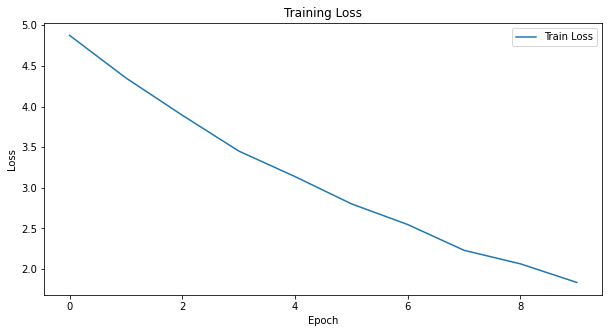

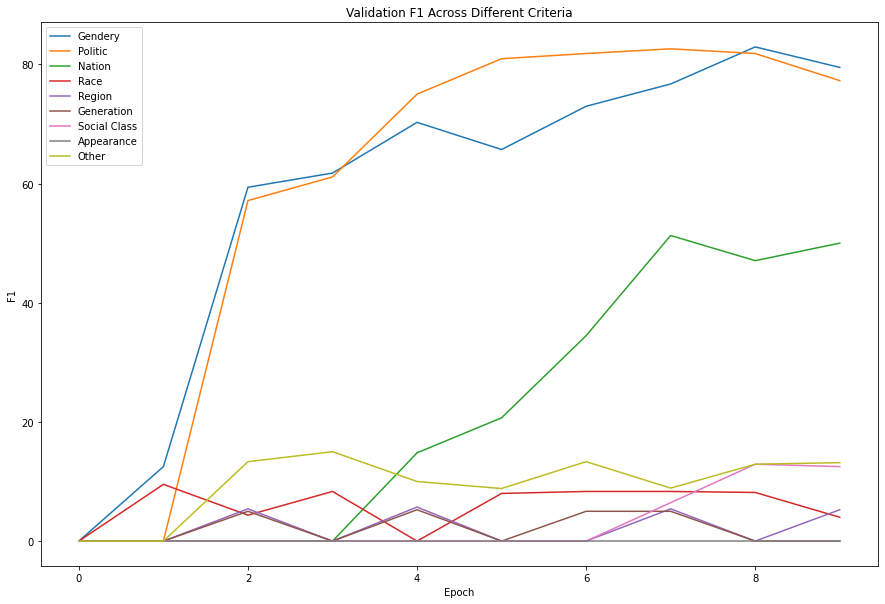

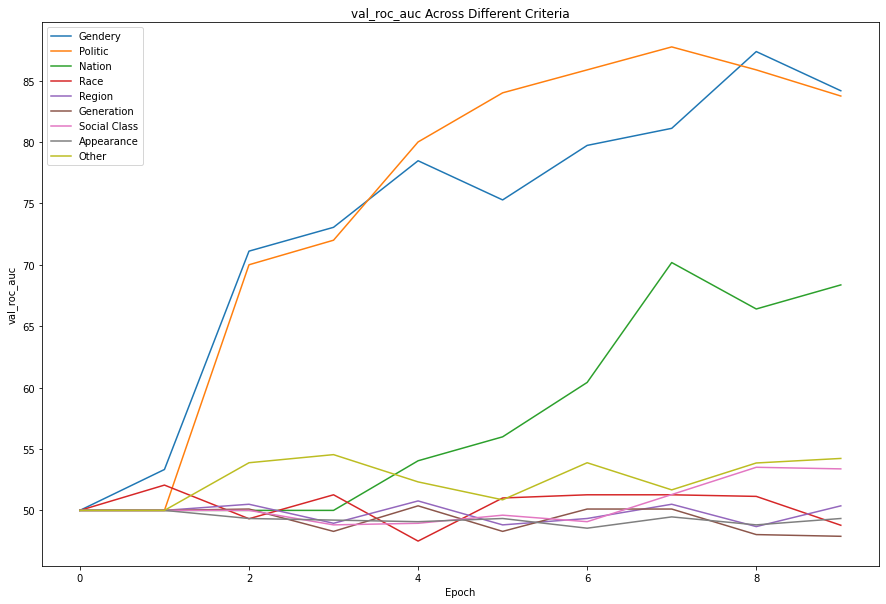

In [45]:
import matplotlib.pyplot as plt

# Training Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Validation Accuracy Graphs
if config.do_eval_during_train:
    # Unzip the val_accuracies list to obtain individual score lists for each evaluation criterion
    val_scores = list(zip(*val_f1))

    plt.figure(figsize=(15, 10))

    labels = [
        "Gendery",
        "Politic",
        "Nation",
        "Race",
        "Region",
        "Generation",
        "Social Class",
        "Appearance",
        "Other"
    ]

    for idx, label in enumerate(labels):
        plt.plot(val_scores[idx], label=label)

    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("Validation F1 Across Different Criteria")
    plt.legend()
    plt.show()
    
if config.do_eval_during_train:
    # Unzip the val_accuracies list to obtain individual score lists for each evaluation criterion
    val_scores = list(zip(*val_roc_auc))

    plt.figure(figsize=(15, 10))

    labels = [
        "Gendery",
        "Politic",
        "Nation",
        "Race",
        "Region",
        "Generation",
        "Social Class",
        "Appearance",
        "Other"
    ]

    for idx, label in enumerate(labels):
        plt.plot(val_scores[idx], label=label)

    plt.xlabel("Epoch")
    plt.ylabel("val_roc_auc")
    plt.title("val_roc_auc Across Different Criteria")
    plt.legend()
    plt.show()

#### Test Dataset Inference

In [ ]:
def inference(model, tokenizer, sentences, device):
    inference_result_1 = []
    inference_result_2 = []
    inference_result_3 = []

    model.eval()
    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer.encode_plus(
                sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=config.max_seq_length
            )
            inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력을 GPU로 이동
            outputs = model(inputs)  # 모델 추론 수행
            outputs_1 = outputs[0]
            outputs_2 = outputs[1]
            outputs_3 = outputs[2]
            outputs_4 = outputs[3]
            outputs_5 = outputs[4]
            outputs_6 = outputs[5]
            outputs_7 = outputs[6]
            outputs_8 = outputs[7]
            outputs_9 = outputs[8]
            
            logits_1 = outputs[0].detach().cpu()
            logits_2 = outputs[1].detach().cpu()
            logits_3 = outputs[2].detach().cpu()
            threshold = 0.5
            predictions_1 = torch.argmax(logits_1, dim=-1)
            predictions_2 = torch.argmax(logits_2, dim=-1)
            predictions_3 = torch.argmax(logits_3, dim=-1)
            inference_result_1.append(predictions_1.item())  # 결과 리스트에 추가
            inference_result_2.append(predictions_2.item())
            inference_result_3.append(predictions_3.item())

    return inference_result_1, inference_result_2, inference_result_3

In [ ]:
test_df = pd.read_csv("test_comments.csv")
sentences_to_infer = test_df["comment"].tolist()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_result_1, inference_result_2, inference_result_3 = inference(model, model.tokenizer, sentences_to_infer, device)

In [ ]:
test_df["선호도"] = inference_result_1
test_df["비속어"] = inference_result_2
test_df["정치"] = inference_result_3

In [ ]:
test_df

In [ ]:
output_csv_path = "inference_results_PSP.csv"
test_df.to_csv(output_csv_path, index=False)

In [ ]:
test_df = pd.read_csv("HJ.csv")
sentences_to_infer = test_df["comment"].tolist()

In [ ]:
from transformers import AutoModelForPreTraining
model = AutoModel.from_pretrained("my_saved_model_directory")